In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:56 - loss: 0.1305 - STD: 1.0702e-04 - MAE: 0.3485

 4/74 [>.............................] - ETA: 2s - loss: 0.0484 - STD: 3.7669e-04 - MAE: 0.1678  

 5/74 [=>............................] - ETA: 2s - loss: 0.0449 - STD: 3.4060e-04 - MAE: 0.1619

 6/74 [=>............................] - ETA: 3s - loss: 0.0434 - STD: 3.0528e-04 - MAE: 0.1605

 7/74 [=>............................] - ETA: 3s - loss: 0.0425 - STD: 2.7473e-04 - MAE: 0.1599

 8/74 [==>...........................] - ETA: 3s - loss: 0.0417 - STD: 2.5065e-04 - MAE: 0.1594

 9/74 [==>...........................] - ETA: 3s - loss: 0.0407 - STD: 2.3280e-04 - MAE: 0.1576

10/74 [===>..........................] - ETA: 3s - loss: 0.0395 - STD: 2.2074e-04 - MAE: 0.1551

11/74 [===>..........................] - ETA: 7s - loss: 0.0390 - STD: 2.1310e-04 - MAE: 0.1517

14/74 [====>.........................] - ETA: 6s - loss: 0.0341 - STD: 2.0749e-04 - MAE: 0.1361

16/74 [=====>........................] - ETA: 5s - loss: 0.0313 - STD: 2.0929e-04 - MAE: 0.1279

17/74 [=====>........................] - ETA: 5s - loss: 0.0302 - STD: 2.1017e-04 - MAE: 0.1260

18/74 [======>.......................] - ETA: 5s - loss: 0.0294 - STD: 2.1111e-04 - MAE: 0.1250

19/74 [======>.......................] - ETA: 4s - loss: 0.0287 - STD: 2.1157e-04 - MAE: 0.1245

20/74 [=======>......................] - ETA: 4s - loss: 0.0281 - STD: 2.1194e-04 - MAE: 0.1241

21/74 [=======>......................] - ETA: 4s - loss: 0.0275 - STD: 2.1242e-04 - MAE: 0.1236

22/74 [=======>......................] - ETA: 4s - loss: 0.0269 - STD: 2.1276e-04 - MAE: 0.1227

23/74 [========>.....................] - ETA: 4s - loss: 0.0264 - STD: 2.1323e-04 - MAE: 0.1216

24/74 [========>.....................] - ETA: 4s - loss: 0.0258 - STD: 2.1358e-04 - MAE: 0.1199

25/74 [=========>....................] - ETA: 4s - loss: 0.0252 - STD: 2.1396e-04 - MAE: 0.1181

26/74 [=========>....................] - ETA: 4s - loss: 0.0247 - STD: 2.1422e-04 - MAE: 0.1161

27/74 [=========>....................] - ETA: 3s - loss: 0.0243 - STD: 2.1449e-04 - MAE: 0.1141

28/74 [==========>...................] - ETA: 3s - loss: 0.0238 - STD: 2.1469e-04 - MAE: 0.1122

29/74 [==========>...................] - ETA: 3s - loss: 0.0235 - STD: 2.1506e-04 - MAE: 0.1104

30/74 [===========>..................] - ETA: 3s - loss: 0.0231 - STD: 2.1551e-04 - MAE: 0.1087

31/74 [===========>..................] - ETA: 3s - loss: 0.0228 - STD: 2.1617e-04 - MAE: 0.1072

32/74 [===========>..................] - ETA: 3s - loss: 0.0226 - STD: 2.1703e-04 - MAE: 0.1058

33/74 [============>.................] - ETA: 3s - loss: 0.0223 - STD: 2.1806e-04 - MAE: 0.1044

34/74 [============>.................] - ETA: 3s - loss: 0.0220 - STD: 2.1929e-04 - MAE: 0.1031

35/74 [=============>................] - ETA: 3s - loss: 0.0217 - STD: 2.2095e-04 - MAE: 0.1019

36/74 [=============>................] - ETA: 3s - loss: 0.0214 - STD: 2.2287e-04 - MAE: 0.1009

37/74 [==============>...............] - ETA: 2s - loss: 0.0212 - STD: 2.2500e-04 - MAE: 0.1000

38/74 [==============>...............] - ETA: 2s - loss: 0.0209 - STD: 2.2731e-04 - MAE: 0.0992

39/74 [==============>...............] - ETA: 2s - loss: 0.0207 - STD: 2.2997e-04 - MAE: 0.0986

40/74 [===============>..............] - ETA: 2s - loss: 0.0205 - STD: 2.3284e-04 - MAE: 0.0981

41/74 [===============>..............] - ETA: 2s - loss: 0.0203 - STD: 2.3588e-04 - MAE: 0.0977

42/74 [================>.............] - ETA: 2s - loss: 0.0201 - STD: 2.3904e-04 - MAE: 0.0973

43/74 [================>.............] - ETA: 2s - loss: 0.0199 - STD: 2.4234e-04 - MAE: 0.0970

44/74 [================>.............] - ETA: 2s - loss: 0.0198 - STD: 2.4582e-04 - MAE: 0.0966

45/74 [=================>............] - ETA: 2s - loss: 0.0196 - STD: 2.4935e-04 - MAE: 0.0962

46/74 [=================>............] - ETA: 2s - loss: 0.0194 - STD: 2.5297e-04 - MAE: 0.0957

47/74 [==================>...........] - ETA: 2s - loss: 0.0193 - STD: 2.5681e-04 - MAE: 0.0952

48/74 [==================>...........] - ETA: 1s - loss: 0.0191 - STD: 2.6067e-04 - MAE: 0.0947

49/74 [==================>...........] - ETA: 1s - loss: 0.0190 - STD: 2.6454e-04 - MAE: 0.0942

50/74 [===================>..........] - ETA: 1s - loss: 0.0188 - STD: 2.6845e-04 - MAE: 0.0936

51/74 [===================>..........] - ETA: 1s - loss: 0.0187 - STD: 2.7263e-04 - MAE: 0.0930

52/74 [====================>.........] - ETA: 1s - loss: 0.0186 - STD: 2.7696e-04 - MAE: 0.0924

53/74 [====================>.........] - ETA: 1s - loss: 0.0184 - STD: 2.8154e-04 - MAE: 0.0919

54/74 [====================>.........] - ETA: 1s - loss: 0.0183 - STD: 2.8637e-04 - MAE: 0.0914

55/74 [=====================>........] - ETA: 1s - loss: 0.0182 - STD: 2.9143e-04 - MAE: 0.0909

56/74 [=====================>........] - ETA: 1s - loss: 0.0181 - STD: 2.9686e-04 - MAE: 0.0904

57/74 [======================>.......] - ETA: 1s - loss: 0.0180 - STD: 3.0252e-04 - MAE: 0.0900

58/74 [======================>.......] - ETA: 1s - loss: 0.0179 - STD: 3.0853e-04 - MAE: 0.0896

59/74 [======================>.......] - ETA: 1s - loss: 0.0178 - STD: 3.1494e-04 - MAE: 0.0892

60/74 [=======================>......] - ETA: 1s - loss: 0.0177 - STD: 3.2178e-04 - MAE: 0.0890

61/74 [=======================>......] - ETA: 0s - loss: 0.0176 - STD: 3.2880e-04 - MAE: 0.0887

62/74 [========================>.....] - ETA: 0s - loss: 0.0175 - STD: 3.3615e-04 - MAE: 0.0884

63/74 [========================>.....] - ETA: 0s - loss: 0.0174 - STD: 3.4383e-04 - MAE: 0.0881

64/74 [========================>.....] - ETA: 0s - loss: 0.0173 - STD: 3.5185e-04 - MAE: 0.0879

65/74 [=========================>....] - ETA: 0s - loss: 0.0172 - STD: 3.6021e-04 - MAE: 0.0876

66/74 [=========================>....] - ETA: 0s - loss: 0.0171 - STD: 3.6920e-04 - MAE: 0.0874

67/74 [==========================>...] - ETA: 0s - loss: 0.0170 - STD: 3.7817e-04 - MAE: 0.0871

68/74 [==========================>...] - ETA: 0s - loss: 0.0170 - STD: 3.8777e-04 - MAE: 0.0868

69/74 [==========================>...] - ETA: 0s - loss: 0.0169 - STD: 3.9784e-04 - MAE: 0.0866

70/74 [===========================>..] - ETA: 0s - loss: 0.0168 - STD: 4.0821e-04 - MAE: 0.0863

71/74 [===========================>..] - ETA: 0s - loss: 0.0167 - STD: 4.1924e-04 - MAE: 0.0860

72/74 [============================>.] - ETA: 0s - loss: 0.0167 - STD: 4.3082e-04 - MAE: 0.0857

73/74 [============================>.] - ETA: 0s - loss: 0.0166 - STD: 4.4289e-04 - MAE: 0.0855

74/74 [==============================] - ETA: 0s - loss: 0.0165 - STD: 4.5549e-04 - MAE: 0.0852

74/74 [==============================] - 8s 83ms/step - loss: 0.0165 - STD: 4.5549e-04 - MAE: 0.0852 - val_loss: 0.0143 - val_STD: 0.0010 - val_MAE: 0.0708


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0116 - STD: 0.0015 - MAE: 0.0662

 3/74 [>.............................] - ETA: 3s - loss: 0.0117 - STD: 0.0016 - MAE: 0.0672

 4/74 [>.............................] - ETA: 3s - loss: 0.0117 - STD: 0.0016 - MAE: 0.0675

 5/74 [=>............................] - ETA: 3s - loss: 0.0117 - STD: 0.0017 - MAE: 0.0678

 6/74 [=>............................] - ETA: 3s - loss: 0.0118 - STD: 0.0017 - MAE: 0.0681

 7/74 [=>............................] - ETA: 4s - loss: 0.0117 - STD: 0.0018 - MAE: 0.0680

 8/74 [==>...........................] - ETA: 4s - loss: 0.0117 - STD: 0.0019 - MAE: 0.0683

 9/74 [==>...........................] - ETA: 3s - loss: 0.0117 - STD: 0.0019 - MAE: 0.0685

10/74 [===>..........................] - ETA: 3s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0686

11/74 [===>..........................] - ETA: 3s - loss: 0.0117 - STD: 0.0021 - MAE: 0.0686

12/74 [===>..........................] - ETA: 3s - loss: 0.0116 - STD: 0.0021 - MAE: 0.0685

13/74 [====>.........................] - ETA: 3s - loss: 0.0116 - STD: 0.0022 - MAE: 0.0685

14/74 [====>.........................] - ETA: 3s - loss: 0.0116 - STD: 0.0023 - MAE: 0.0683

15/74 [=====>........................] - ETA: 3s - loss: 0.0116 - STD: 0.0024 - MAE: 0.0683

16/74 [=====>........................] - ETA: 3s - loss: 0.0116 - STD: 0.0025 - MAE: 0.0682

17/74 [=====>........................] - ETA: 3s - loss: 0.0116 - STD: 0.0026 - MAE: 0.0680

18/74 [======>.......................] - ETA: 3s - loss: 0.0116 - STD: 0.0027 - MAE: 0.0679

19/74 [======>.......................] - ETA: 3s - loss: 0.0115 - STD: 0.0028 - MAE: 0.0677

20/74 [=======>......................] - ETA: 3s - loss: 0.0115 - STD: 0.0029 - MAE: 0.0676

21/74 [=======>......................] - ETA: 3s - loss: 0.0115 - STD: 0.0030 - MAE: 0.0675

22/74 [=======>......................] - ETA: 3s - loss: 0.0115 - STD: 0.0031 - MAE: 0.0674

23/74 [========>.....................] - ETA: 3s - loss: 0.0114 - STD: 0.0033 - MAE: 0.0674

24/74 [========>.....................] - ETA: 3s - loss: 0.0114 - STD: 0.0034 - MAE: 0.0673

25/74 [=========>....................] - ETA: 3s - loss: 0.0114 - STD: 0.0036 - MAE: 0.0672

26/74 [=========>....................] - ETA: 3s - loss: 0.0114 - STD: 0.0037 - MAE: 0.0671

27/74 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 0.0039 - MAE: 0.0671

28/74 [==========>...................] - ETA: 3s - loss: 0.0113 - STD: 0.0041 - MAE: 0.0670

29/74 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 0.0043 - MAE: 0.0669

30/74 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 0.0045 - MAE: 0.0668

31/74 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 0.0047 - MAE: 0.0666

32/74 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 0.0050 - MAE: 0.0665

33/74 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 0.0053 - MAE: 0.0664

34/74 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 0.0055 - MAE: 0.0663

35/74 [=============>................] - ETA: 2s - loss: 0.0111 - STD: 0.0059 - MAE: 0.0662

36/74 [=============>................] - ETA: 2s - loss: 0.0110 - STD: 0.0062 - MAE: 0.0660

37/74 [==============>...............] - ETA: 2s - loss: 0.0110 - STD: 0.0065 - MAE: 0.0659

38/74 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.0069 - MAE: 0.0657

39/74 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.0073 - MAE: 0.0655

40/74 [===============>..............] - ETA: 2s - loss: 0.0108 - STD: 0.0077 - MAE: 0.0653

41/74 [===============>..............] - ETA: 2s - loss: 0.0107 - STD: 0.0082 - MAE: 0.0650

42/74 [================>.............] - ETA: 2s - loss: 0.0107 - STD: 0.0086 - MAE: 0.0648

43/74 [================>.............] - ETA: 2s - loss: 0.0106 - STD: 0.0091 - MAE: 0.0646

44/74 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 0.0097 - MAE: 0.0643

45/74 [=================>............] - ETA: 1s - loss: 0.0105 - STD: 0.0102 - MAE: 0.0640

46/74 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0108 - MAE: 0.0637

47/74 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0115 - MAE: 0.0634

48/74 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 0.0121 - MAE: 0.0632

49/74 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 0.0128 - MAE: 0.0628

50/74 [===================>..........] - ETA: 1s - loss: 0.0101 - STD: 0.0136 - MAE: 0.0625

51/74 [===================>..........] - ETA: 1s - loss: 0.0100 - STD: 0.0143 - MAE: 0.0622

52/74 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 0.0151 - MAE: 0.0619

53/74 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0159 - MAE: 0.0615

54/74 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0167 - MAE: 0.0611

55/74 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0175 - MAE: 0.0608

56/74 [=====================>........] - ETA: 1s - loss: 0.0095 - STD: 0.0183 - MAE: 0.0604

57/74 [======================>.......] - ETA: 1s - loss: 0.0094 - STD: 0.0192 - MAE: 0.0601

58/74 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0200 - MAE: 0.0597

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0209 - MAE: 0.0594

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0217 - MAE: 0.0591

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0226 - MAE: 0.0587

62/74 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0235 - MAE: 0.0584

63/74 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.0244 - MAE: 0.0580

64/74 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0253 - MAE: 0.0577

65/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0262 - MAE: 0.0574

66/74 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0270 - MAE: 0.0571

67/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0279 - MAE: 0.0568

68/74 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0288 - MAE: 0.0565

69/74 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0296 - MAE: 0.0562

70/74 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0305 - MAE: 0.0559

71/74 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0313 - MAE: 0.0556

72/74 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0321 - MAE: 0.0554

73/74 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0328 - MAE: 0.0551

74/74 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0336 - MAE: 0.0548

74/74 [==============================] - 5s 70ms/step - loss: 0.0080 - STD: 0.0336 - MAE: 0.0548 - val_loss: 0.0031 - val_STD: 0.0671 - val_MAE: 0.0355


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0904 - MAE: 0.0359

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0356

 3/74 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0903 - MAE: 0.0353

 4/74 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0903 - MAE: 0.0349

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0897 - MAE: 0.0348

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0895 - MAE: 0.0348

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0897 - MAE: 0.0347

 8/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0899 - MAE: 0.0348

 9/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0903 - MAE: 0.0347

10/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0348

11/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0347

12/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

13/74 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0911 - MAE: 0.0347

14/74 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0912 - MAE: 0.0347

15/74 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0913 - MAE: 0.0346

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0915 - MAE: 0.0346

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0914 - MAE: 0.0346

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0917 - MAE: 0.0345

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0918 - MAE: 0.0345

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0919 - MAE: 0.0345

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0344

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0344

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0920 - MAE: 0.0344

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0922 - MAE: 0.0343

25/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0923 - MAE: 0.0343

26/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0924 - MAE: 0.0343

27/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0925 - MAE: 0.0343

28/74 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0925 - MAE: 0.0342

29/74 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0926 - MAE: 0.0342

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0927 - MAE: 0.0342

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0927 - MAE: 0.0342

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0928 - MAE: 0.0341

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0929 - MAE: 0.0341

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0930 - MAE: 0.0341

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0930 - MAE: 0.0341

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0931 - MAE: 0.0340

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0931 - MAE: 0.0340

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0340

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0340

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0339

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0932 - MAE: 0.0339

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0933 - MAE: 0.0339

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0934 - MAE: 0.0339

44/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0935 - MAE: 0.0338

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0937 - MAE: 0.0338

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0937 - MAE: 0.0338

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0937 - MAE: 0.0338

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0938 - MAE: 0.0337

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0938 - MAE: 0.0337

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0938 - MAE: 0.0337

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0939 - MAE: 0.0337

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0939 - MAE: 0.0337

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0939 - MAE: 0.0337

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0940 - MAE: 0.0336

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0336

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0336

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0336

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0941 - MAE: 0.0336

60/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0942 - MAE: 0.0335

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0942 - MAE: 0.0335

62/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0335

63/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0335

64/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0335

65/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0335

66/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0334

67/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0334

68/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0334

69/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0334

70/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0334

71/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0333

72/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0333

73/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0333

74/74 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0333

74/74 [==============================] - 5s 70ms/step - loss: 0.0026 - STD: 0.0946 - MAE: 0.0333 - val_loss: 0.0026 - val_STD: 0.0735 - val_MAE: 0.0330


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0992 - MAE: 0.0325

 2/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

 3/74 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

 4/74 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0326

 5/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

 6/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0325

 7/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0323

 8/74 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0323

 9/74 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0322

10/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0322

11/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0321

12/74 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0321

13/74 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0321

14/74 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0321

15/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0321

16/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0320

17/74 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0320

18/74 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0320

19/74 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0320

20/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0319

21/74 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0319

22/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0966 - MAE: 0.0319

23/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0319

24/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0966 - MAE: 0.0319

25/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0318

26/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0966 - MAE: 0.0318

27/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0319

28/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0318

29/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0318

30/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0318

31/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0318

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0318

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0318

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0318

35/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

39/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0317

40/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0317

41/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0317

42/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0317

43/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0316

44/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

45/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

46/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

47/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

48/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

49/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

50/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

51/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0316

52/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

53/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0315

54/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

55/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

56/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

57/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

58/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0314

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0314

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0314

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0314

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0314

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

74/74 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313 - val_loss: 0.0024 - val_STD: 0.0743 - val_MAE: 0.0313


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0306

 2/74 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0975 - MAE: 0.0305

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0308

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0306

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0306

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

14/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0307

15/74 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0307

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0307

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0307

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0308

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0308

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0308

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0308

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0307

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0307

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0306

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0306

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0306

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0306

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0306

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0306

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0306

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0305

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0305

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0304

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0304

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0304

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0303

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303

74/74 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.0988 - MAE: 0.0303 - val_loss: 0.0022 - val_STD: 0.0767 - val_MAE: 0.0309


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0295

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0295

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0296

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0296

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0295

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0295

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0295

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

29/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0297

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0296

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0295

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

74/74 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295 - val_loss: 0.0021 - val_STD: 0.0785 - val_MAE: 0.0304


Epoch 7/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0286

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0294

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0295

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0294

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0295

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0295

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0294

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0294

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0294

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0294

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290 - val_loss: 0.0021 - val_STD: 0.0774 - val_MAE: 0.0296


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0282

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0985 - MAE: 0.0291

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0288

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0288

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

74/74 [==============================] - 5s 71ms/step - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287 - val_loss: 0.0020 - val_STD: 0.0783 - val_MAE: 0.0300


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0989 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0989 - MAE: 0.0280

 4/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0283

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

15/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0287

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285 - val_loss: 0.0021 - val_STD: 0.0811 - val_MAE: 0.0306


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0287

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0284

 3/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

 4/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

15/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

16/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0788 - val_MAE: 0.0292


Epoch 11/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0280

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0279

 3/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0279

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0279

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0797 - val_MAE: 0.0292


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0284

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0284

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - 5s 68ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0766 - val_MAE: 0.0293


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0956 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0284

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0787 - val_MAE: 0.0287


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0275

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0294

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0291

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0291

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0288

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0287

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0284

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

23/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

24/74 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0281

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

74/74 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282 - val_loss: 0.0019 - val_STD: 0.0809 - val_MAE: 0.0293


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0290

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0300

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0296

 8/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0301

 9/74 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0300

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0303

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0301

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0300

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0296

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0295

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0293

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0291

23/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0290

24/74 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0289

25/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0289

26/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0288

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0287

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0287

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

40/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - 5s 63ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0809 - val_MAE: 0.0289


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0276

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

74/74 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0795 - val_MAE: 0.0286


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0277

25/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

26/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0279

27/74 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0279

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

41/74 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

42/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

43/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - 5s 64ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0797 - val_MAE: 0.0285


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

74/74 [==============================] - 5s 62ms/step - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278 - val_loss: 0.0023 - val_STD: 0.0725 - val_MAE: 0.0315


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0325

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0964 - MAE: 0.0296

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0305

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0315

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0306

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0317

 7/74 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0317

 8/74 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0316

 9/74 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0319

10/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0314

11/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0314

12/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0310

13/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0308

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0306

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0305

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0303

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0302

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0301

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0299

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0299

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0297

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0297

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0296

24/74 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0296

25/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

26/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0294

27/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0294

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0293

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0293

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0289

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0288

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0288

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

41/74 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

42/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 5s 66ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0794 - val_MAE: 0.0284


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

 3/74 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

74/74 [==============================] - 5s 63ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270 - val_loss: 0.0019 - val_STD: 0.0783 - val_MAE: 0.0283


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0262

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1008 - MAE: 0.0264

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0266

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

22/74 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

23/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0818 - val_MAE: 0.0300


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0273

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0272

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0273

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

21/74 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

22/74 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

23/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

74/74 [==============================] - 5s 61ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0795 - val_MAE: 0.0282


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0268

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0268

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0791 - val_MAE: 0.0284


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0263

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0268

 5/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0269

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0273

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0273

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

23/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

74/74 [==============================] - 5s 61ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0810 - val_MAE: 0.0297


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0268

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

23/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0797 - val_MAE: 0.0285


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1001 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0270

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

 4/74 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0273

 5/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0271

 6/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

 7/74 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

10/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

24/74 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

25/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

27/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

28/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

40/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

41/74 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

42/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

43/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0780 - val_MAE: 0.0282


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.0971 - MAE: 0.0262

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0980 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0266

 4/74 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.0999 - MAE: 0.0266

 5/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0266

 6/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0266

 7/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0267

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0267

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0267

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0266

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0266

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

23/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

39/74 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

40/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - 5s 62ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0283


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0261

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

30/74 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277

74/74 [==============================] - 5s 66ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0277 - val_loss: 0.0020 - val_STD: 0.0744 - val_MAE: 0.0284


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0279

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0284

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0276

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0791 - val_MAE: 0.0283


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0808 - val_MAE: 0.0281


Epoch 31/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0265

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

29/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0792 - val_MAE: 0.0280


Epoch 32/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

 3/74 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0261

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0261

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0261

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0261

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0261

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0261

15/74 [=====>........................] - ETA: 4s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0261

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0261

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0261

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0262

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0262

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0262

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0263

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0803 - val_MAE: 0.0288


Epoch 33/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0259

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

 9/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

10/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

11/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

12/74 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

13/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

14/74 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0260

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0261

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0261

25/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0261

26/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0261

27/74 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0261

28/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

74/74 [==============================] - 5s 69ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267 - val_loss: 0.0020 - val_STD: 0.0736 - val_MAE: 0.0291


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0957 - MAE: 0.0285

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0276

 4/74 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

 5/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0263

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

44/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

59/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0823 - val_MAE: 0.0303


Epoch 35/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0269

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0270

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0263

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0264

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0265

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0265

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0265

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0264

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0263

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0821 - val_MAE: 0.0291


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0259

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1006 - MAE: 0.0263

 3/74 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0273

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

28/74 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

29/74 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0263

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

41/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

42/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

43/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

44/74 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

58/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

59/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - 5s 70ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0819 - val_MAE: 0.0305


Epoch 37/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0268

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0263

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0262

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0276

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0278

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0277

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0269

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

41/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

42/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

43/74 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

58/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - 5s 69ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0799 - val_MAE: 0.0284


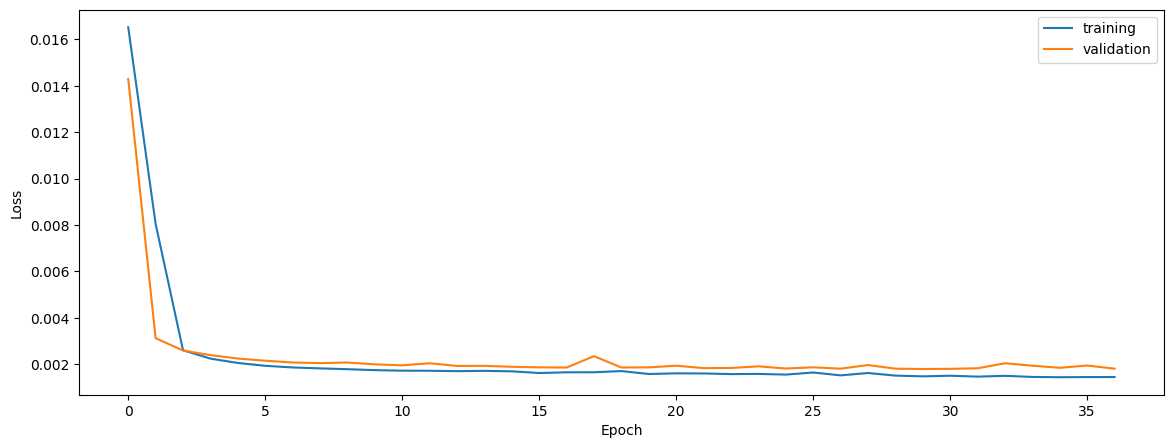

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


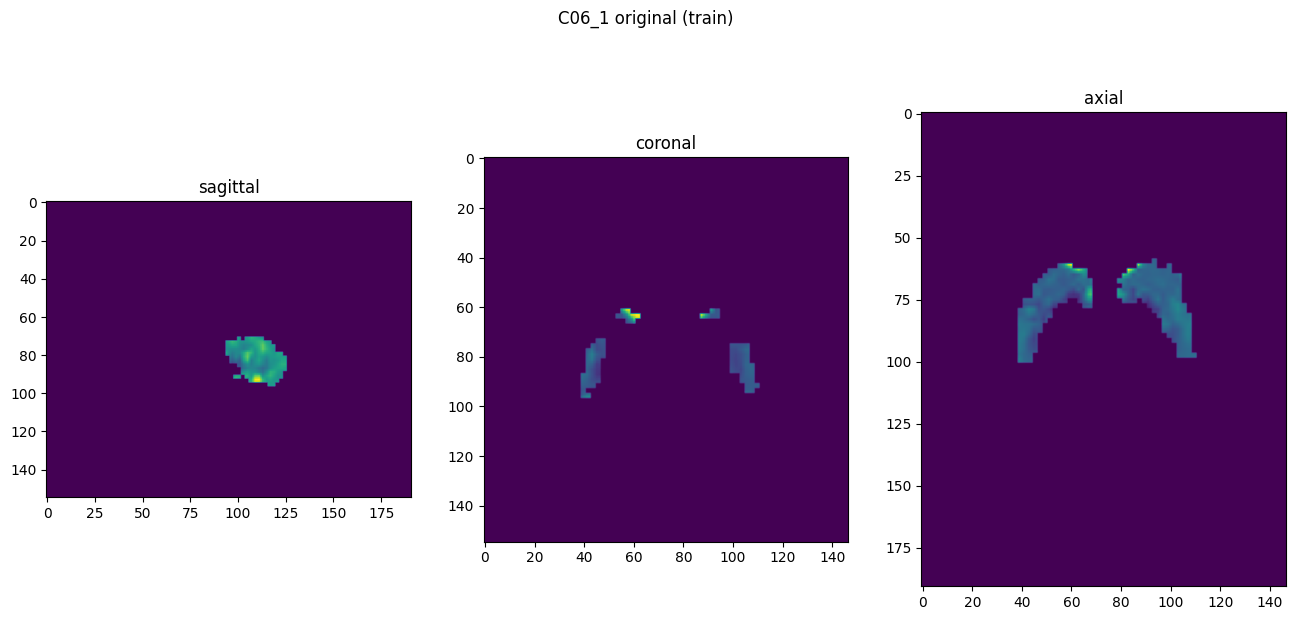

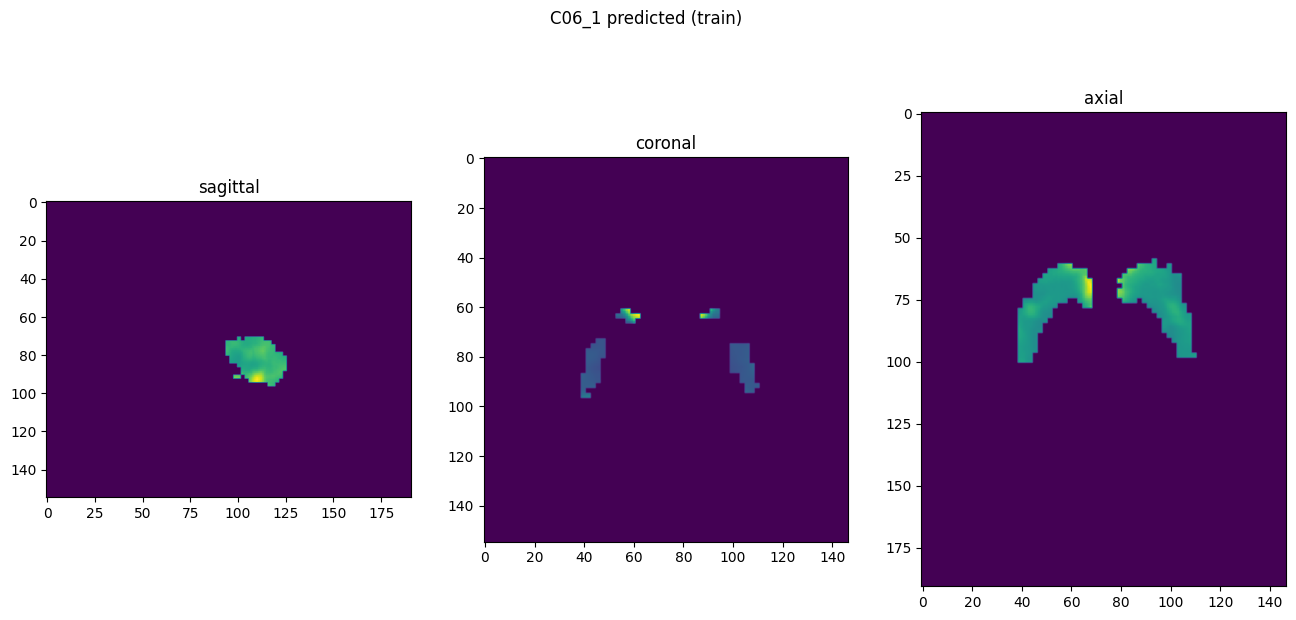

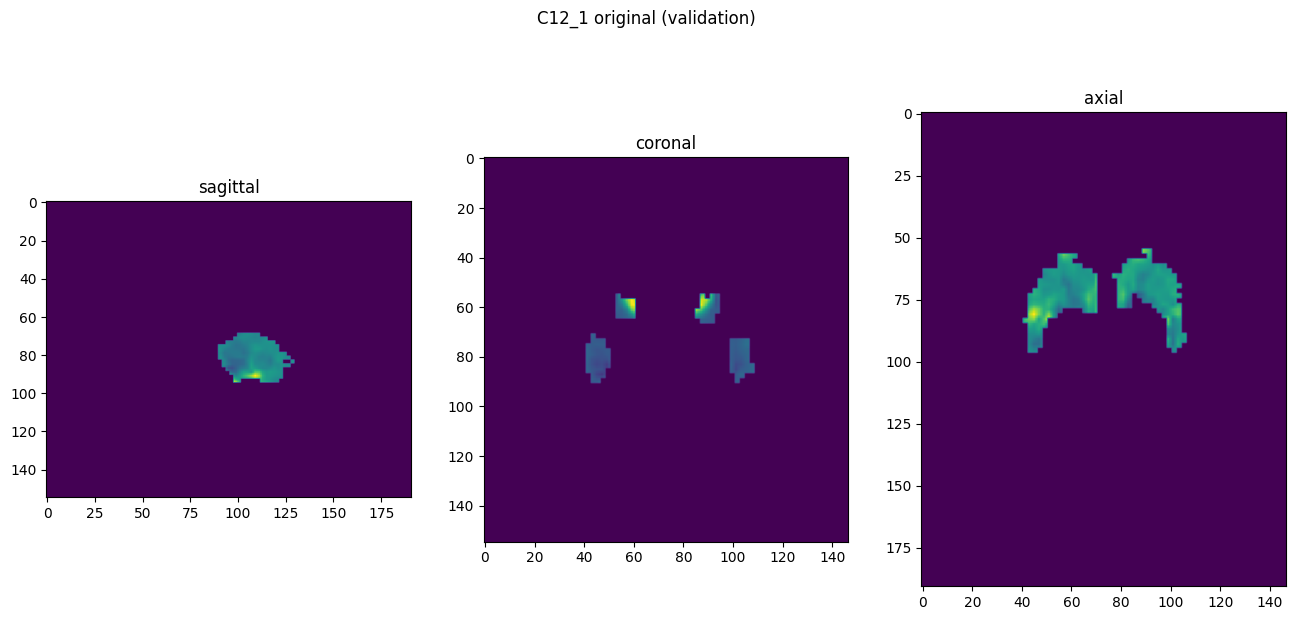

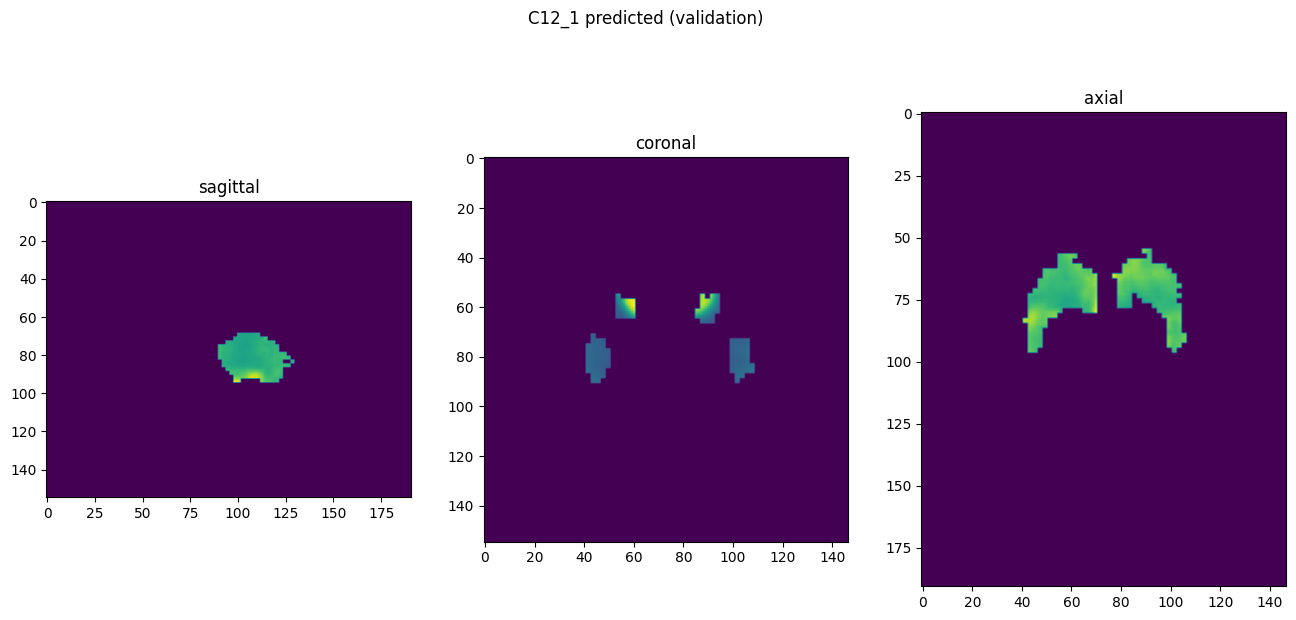

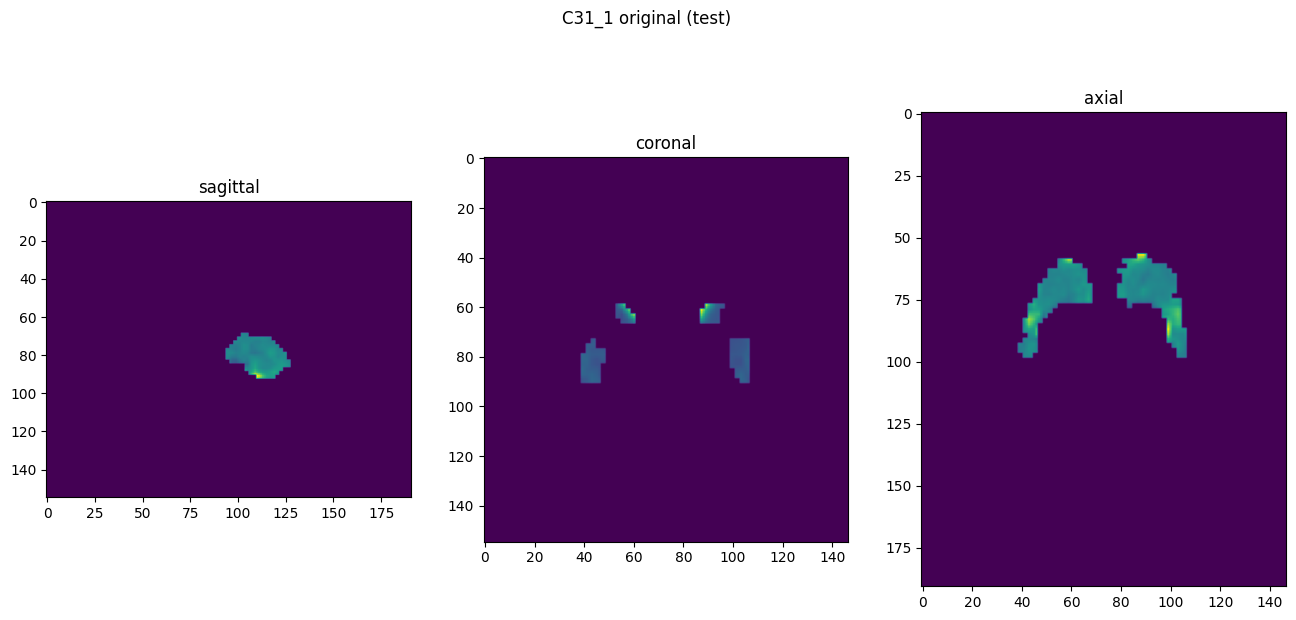

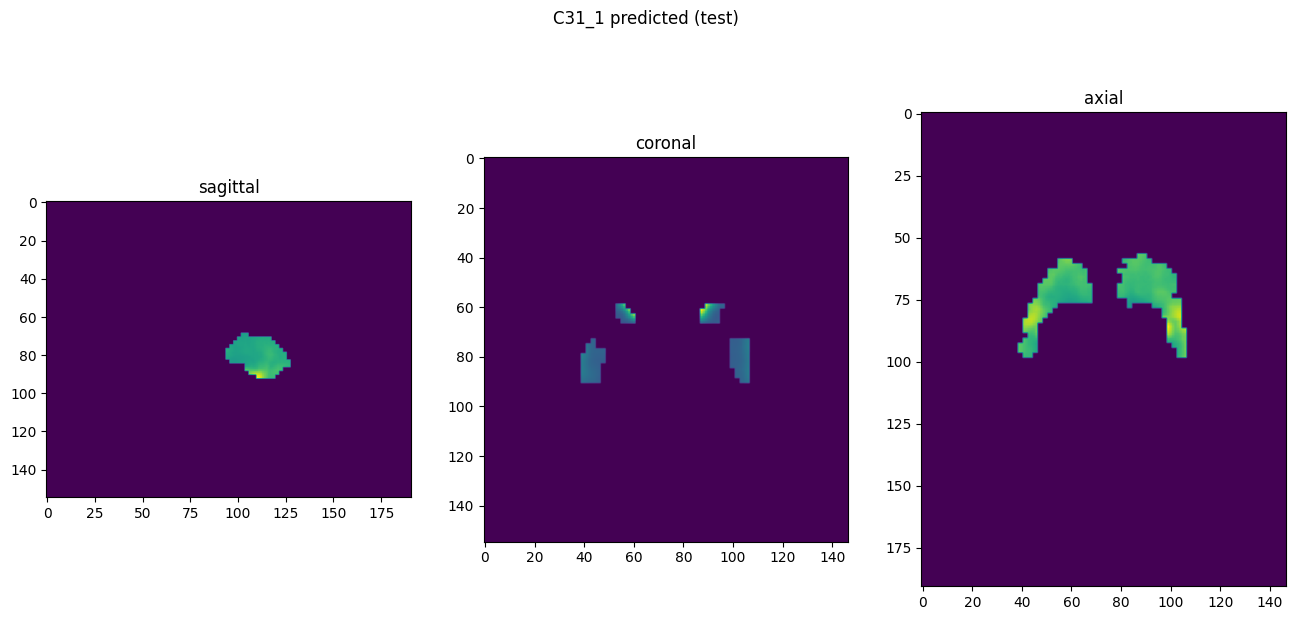

In [10]:
showResults(model, gen, threshold=None, background=False)